In [ ]:
!pip install opencv-python-headless Flask flask-ngrok


In [ ]:
def detect_items(frame):
    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    detected_items = []
    for i in range(len(boxes)):
        if i in indexes:
            box = boxes[i]
            detected_items.append({
                "class": classes[class_ids[i]],
                "confidence": confidences[i],
                "box": box
            })

    return detected_items


In [ ]:
%%writefile app.py
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
import cv2
import numpy as np

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when the app is run

@app.route('/')
def index():
    return '''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Video X-Ray Shopping</title>
    </head>
    <body>
        <h1>Video X-Ray Shopping</h1>
        <form id="uploadForm" enctype="multipart/form-data">
            <input type="file" name="video_frame" accept="image/*">
            <button type="submit">Upload Frame</button>
        </form>
        <div id="results"></div>

        <script>
            document.getElementById('uploadForm').onsubmit = async (e) => {
                e.preventDefault();
                let formData = new FormData(e.target);
                let response = await fetch('/detect', {
                    method: 'POST',
                    body: formData
                });
                let result = await response.json();
                let resultsDiv = document.getElementById('results');
                resultsDiv.innerHTML = '';
                result.forEach(item => {
                    let div = document.createElement('div');
                    div.innerHTML = `<h3>${item.product.name}</h3><p>${item.product.price}</p><img src="${item.product.image_url}" alt="${item.product.name}">`;
                    resultsDiv.appendChild(div);
                });
            }
        </script>
    </body>
    </html>
    '''

@app.route('/detect', methods=['POST'])
def detect():
    file = request.files['video_frame']
    frame = cv2.imdecode(np.frombuffer(file.read(), np.uint8), cv2.IMREAD_COLOR)
    items = detect_items(frame)

    product_info = []
    for item in items:
        product_details = query_amazon_api(item["class"])
        product_info.append({
            "item": item,
            "product": product_details
        })

    return jsonify(product_info)

def query_amazon_api(item_name):
    # Placeholder function to simulate querying Amazon API
    # For demo purposes, returning dummy data
    return {
        "name": f"Product for {item_name}",
        "price": "$99.99",
        "image_url": "https://via.placeholder.com/150"
    }

if __name__ == '__main__':
    app.run()


Writing app.py


In [ ]:
!python app.py


 * Serving Flask app 'app'
 * Debug mode: off
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
Usage of ngrok requires a verified account and authtoken.

Sign up for an account: https://dashboard.ngrok.com/signup
Install your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken

ERR_NGROK_4018

Exception in thread Thread-1:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.p

In [ ]:
!pip install opencv-python-headless Flask flask-ngrok



In [ ]:
import cv2
import numpy as np

# Download YOLOv3 weights and config files
!wget -q https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
!wget -q https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg -O yolov3.cfg
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names

# Load YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load COCO labels
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]


In [ ]:
def detect_items(frame):
    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    detected_items = []
    for i in range(len(boxes)):
        if i in indexes:
            box = boxes[i]
            detected_items.append({
                "class": classes[class_ids[i]],
                "confidence": confidences[i],
                "box": box
            })

    return detected_items

def query_amazon_api(item_name):
    # Placeholder function to simulate querying Amazon API
    # For demo purposes, returning dummy data
    return {
        "name": f"Product for {item_name}",
        "price": "$99.99",
        "image_url": "https://via.placeholder.com/150"
    }


In [ ]:
%%writefile app.py
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
import cv2
import numpy as np

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when the app is run

@app.route('/')
def index():
    return '''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Enhanced Shopping Experience</title>
    </head>
    <body>
        <h1>Enhanced Shopping Experience</h1>
        <form id="uploadForm" enctype="multipart/form-data">
            <input type="file" name="image" accept="image/*">
            <button type="submit">Search by Image</button>
        </form>
        <div id="results"></div>

        <script>
            document.getElementById('uploadForm').onsubmit = async (e) => {
                e.preventDefault();
                let formData = new FormData(e.target);
                let response = await fetch('/search', {
                    method: 'POST',
                    body: formData
                });
                let result = await response.json();
                let resultsDiv = document.getElementById('results');
                resultsDiv.innerHTML = '';
                result.forEach(item => {
                    let div = document.createElement('div');
                    div.innerHTML = `<h3>${item.product.name}</h3><p>${item.product.price}</p><img src="${item.product.image_url}" alt="${item.product.name}">`;
                    resultsDiv.appendChild(div);
                });
            }
        </script>
    </body>
    </html>
    '''

@app.route('/search', methods=['POST'])
def search():
    file = request.files['image']
    frame = cv2.imdecode(np.frombuffer(file.read(), np.uint8), cv2.IMREAD_COLOR)
    items = detect_items(frame)

    product_info = []
    for item in items:
        product_details = query_amazon_api(item["class"])
        product_info.append({
            "item": item,
            "product": product_details
        })

    return jsonify(product_info)

if __name__ == '__main__':
    app.run()


Overwriting app.py


In [ ]:
!python app.py


 * Serving Flask app 'app'
 * Debug mode: off
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
Usage of ngrok requires a verified account and authtoken.

Sign up for an account: https://dashboard.ngrok.com/signup
Install your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken

ERR_NGROK_4018

Exception in thread Thread-1:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.p

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

Saving WhatsApp Video 2024-06-22 at 00.47.16_a835390b.mp4 to WhatsApp Video 2024-06-22 at 00.47.16_a835390b.mp4
Detected object: chair, Confidence: 0.98, Size: 115x207, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.92, Size: 92x199, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.60, Size: 27x62, Color: [ 78.58771295 241.70705557  69.22208794]


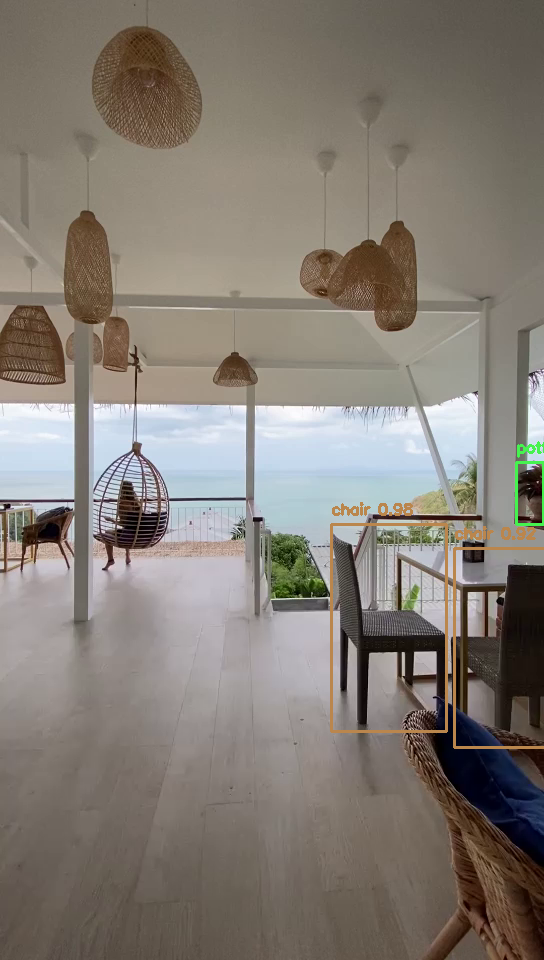

Detected object: chair, Confidence: 0.98, Size: 114x205, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.94, Size: 92x201, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.61, Size: 27x62, Color: [ 78.58771295 241.70705557  69.22208794]


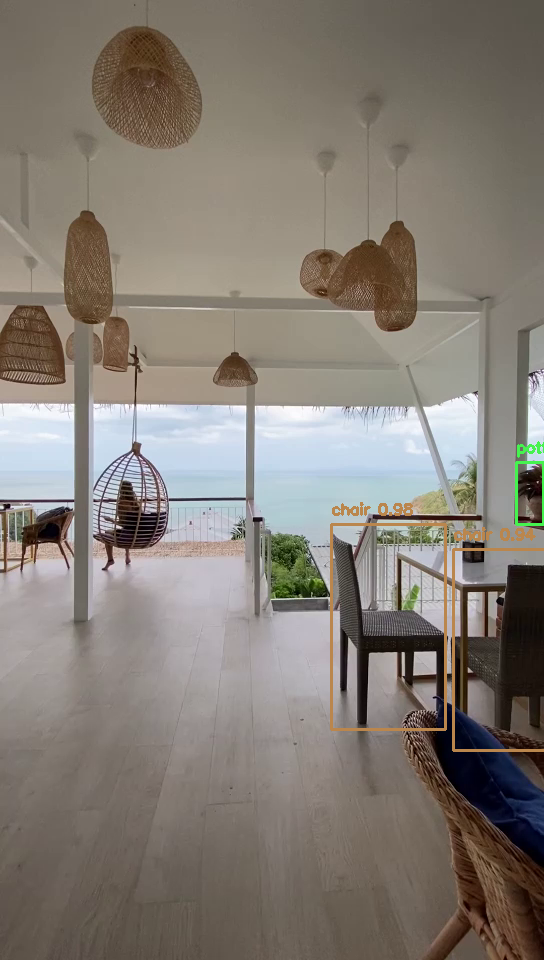

Detected object: chair, Confidence: 0.97, Size: 114x205, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.94, Size: 92x200, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.58, Size: 27x62, Color: [ 78.58771295 241.70705557  69.22208794]


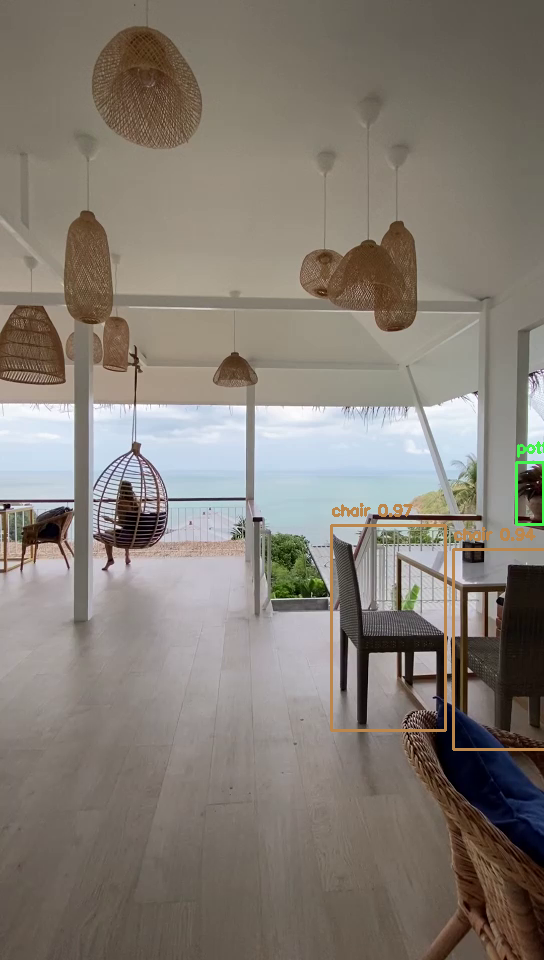

Detected object: chair, Confidence: 0.98, Size: 114x205, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.94, Size: 92x201, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.60, Size: 27x62, Color: [ 78.58771295 241.70705557  69.22208794]


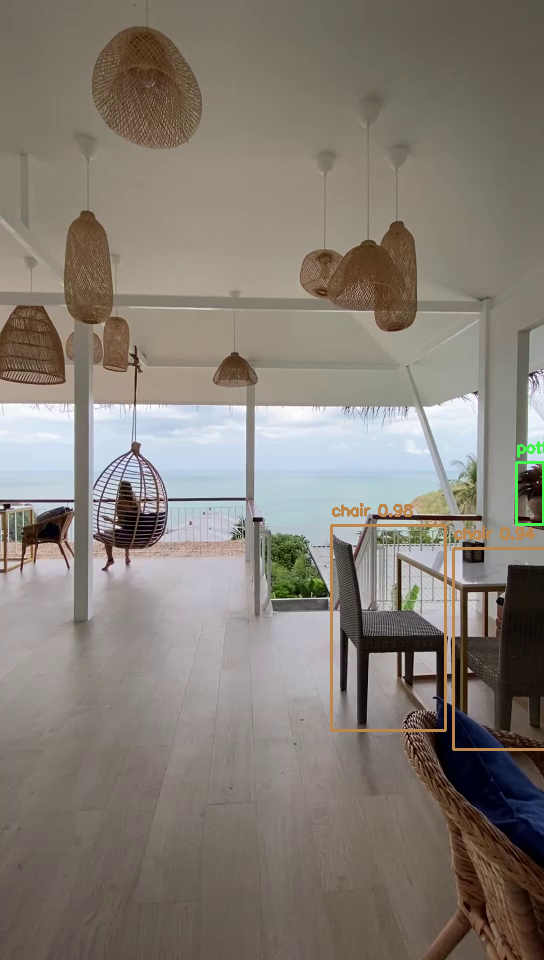

Detected object: chair, Confidence: 0.98, Size: 113x205, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.94, Size: 92x199, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.62, Size: 27x62, Color: [ 78.58771295 241.70705557  69.22208794]


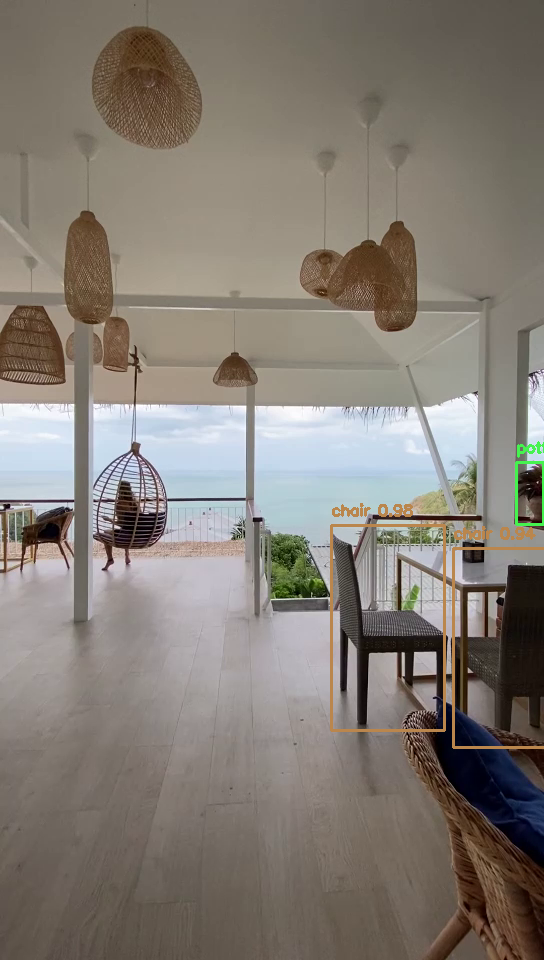

Detected object: chair, Confidence: 0.97, Size: 114x207, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.93, Size: 92x198, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.63, Size: 27x62, Color: [ 78.58771295 241.70705557  69.22208794]


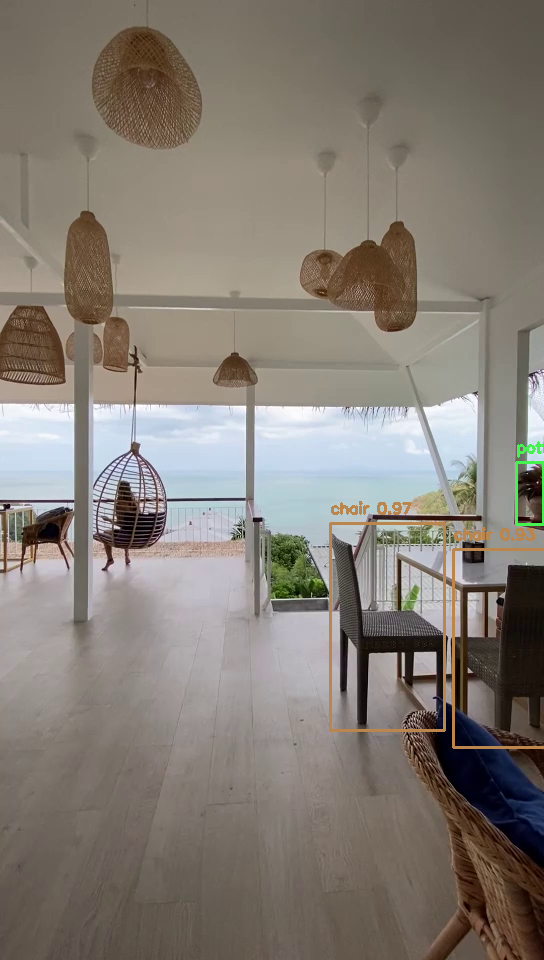

Detected object: chair, Confidence: 0.97, Size: 114x207, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.94, Size: 91x199, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.68, Size: 27x62, Color: [ 78.58771295 241.70705557  69.22208794]


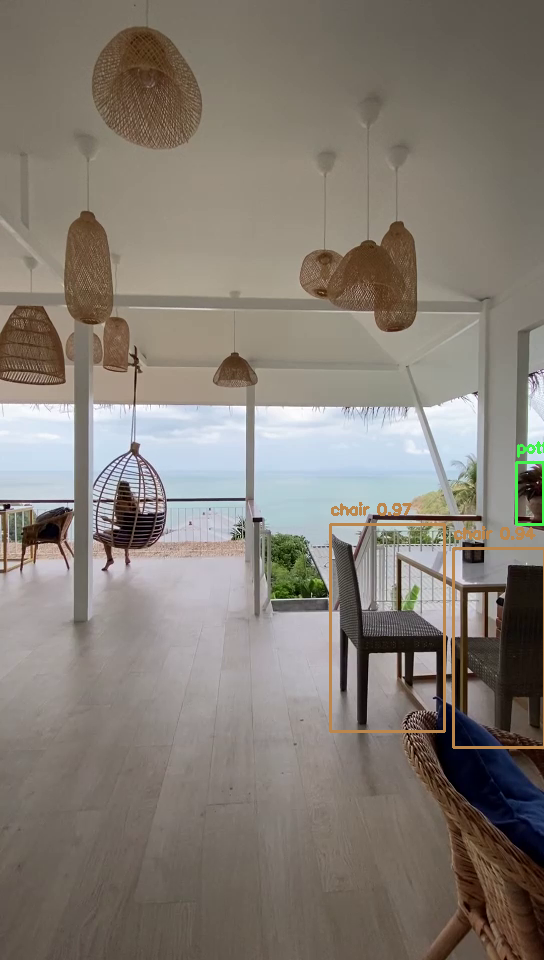

Detected object: chair, Confidence: 0.98, Size: 114x207, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.93, Size: 91x199, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.65, Size: 27x61, Color: [ 78.58771295 241.70705557  69.22208794]


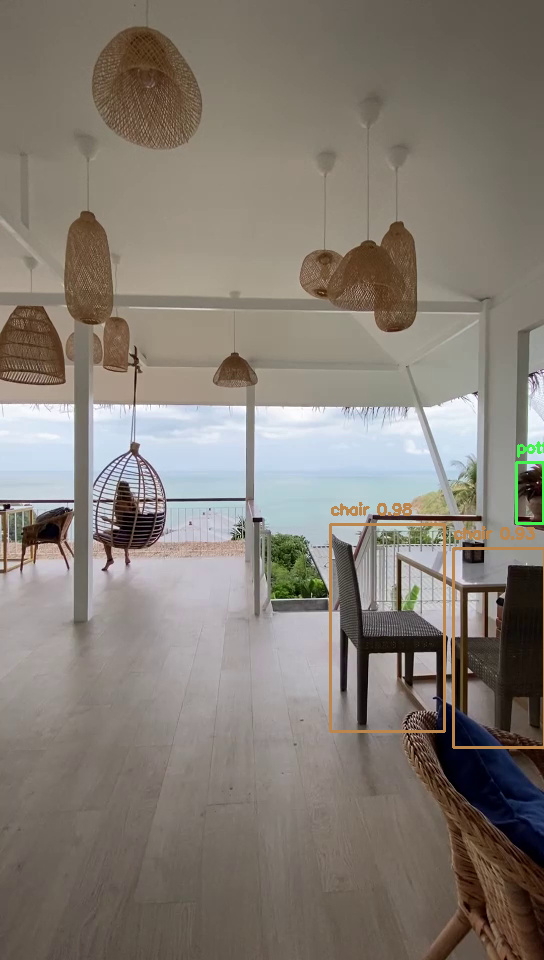

Detected object: chair, Confidence: 0.98, Size: 114x209, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.93, Size: 92x199, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.63, Size: 27x62, Color: [ 78.58771295 241.70705557  69.22208794]


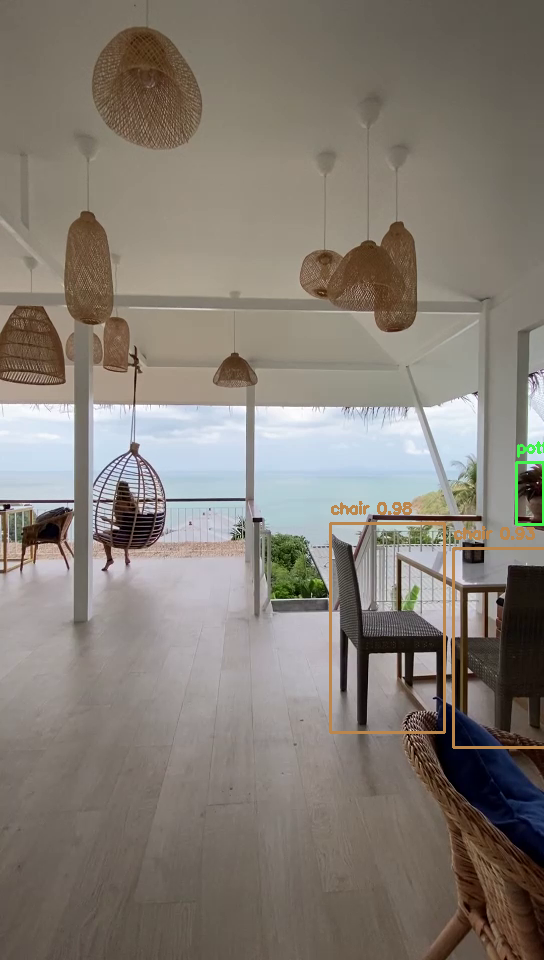

Detected object: chair, Confidence: 0.98, Size: 113x211, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.93, Size: 93x199, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.65, Size: 27x62, Color: [ 78.58771295 241.70705557  69.22208794]


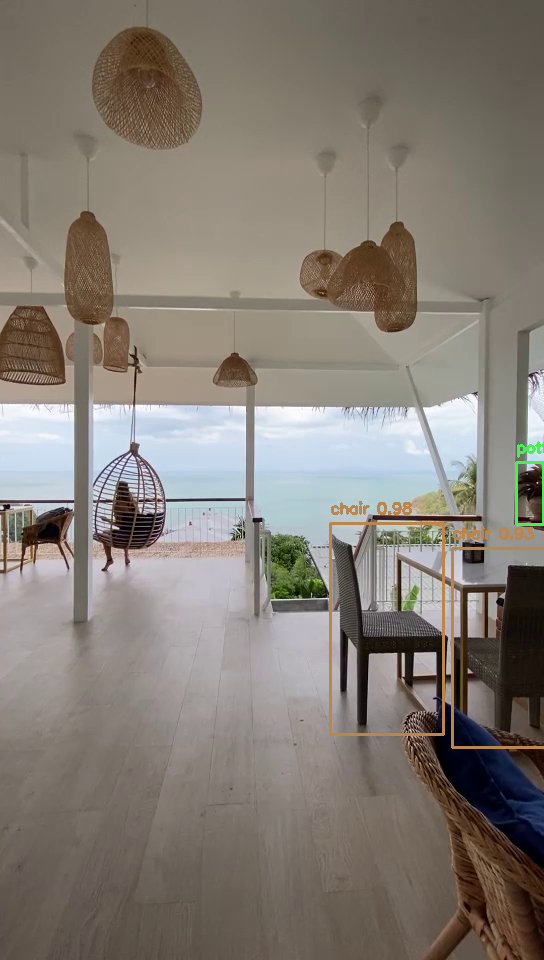

Detected object: chair, Confidence: 0.98, Size: 113x212, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.92, Size: 93x200, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.59, Size: 27x61, Color: [ 78.58771295 241.70705557  69.22208794]


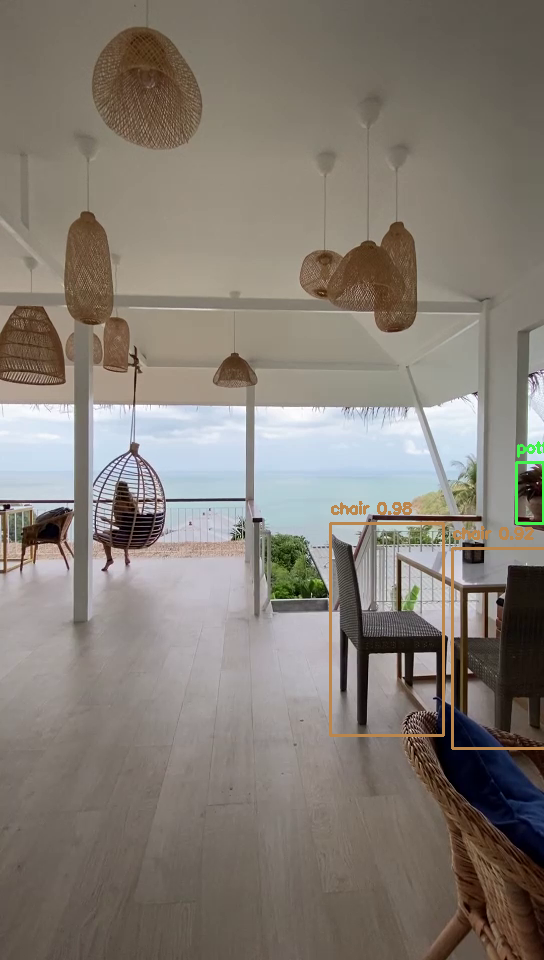

Detected object: chair, Confidence: 0.98, Size: 113x211, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: chair, Confidence: 0.92, Size: 93x200, Color: [ 76.94169781 133.72901733 186.43267474]
Detected object: pottedplant, Confidence: 0.56, Size: 27x62, Color: [ 78.58771295 241.70705557  69.22208794]


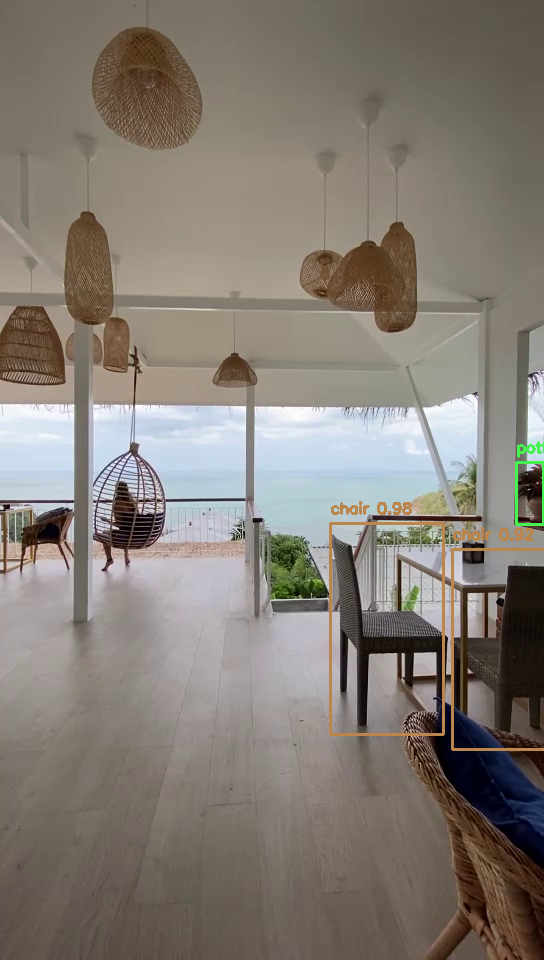

In [ ]:
# Install required libraries
!pip install opencv-python-headless
!pip install torch torchvision

# Download YOLO files
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

# Upload video file
from google.colab import files
uploaded = files.upload()

# Object detection code
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load class labels
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Open the video file
cap = cv2.VideoCapture(next(iter(uploaded)))

# Function to generate Amazon search URLs
def get_amazon_search_url(query, color=None, size=None):
    base_url = "https://www.amazon.com/s?k="
    search_query = query.replace(" ", "+")
    if color:
        search_query += f"+{color.replace(' ', '+')}"
    if size:
        search_query += f"+{size.replace(' ', '+')}"
    return base_url + search_query

# Process the video
detected_objects = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    height, width, channels = frame.shape

    # Detecting objects
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Show information on the screen
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]
            color = colors[class_ids[i]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            print(f"Detected object: {label}, Confidence: {confidence:.2f}, Size: {w}x{h}, Color: {color}")

            # Save detected object details
            detected_objects.append({'label': label, 'confidence': confidence, 'size': f"{w}x{h}", 'color': color})

    # Display the frame
    cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Generate Amazon search links
for obj in detected_objects:
    search_url = get_amazon_search_url(obj['label'], color=obj['color'], size=obj['size'])
    print(f"Search for {obj['label']} on Amazon: {search_url}")


In [ ]:
import cv2
import numpy as np

# Download YOLOv3 weights and config files
!wget -q https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
!wget -q https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg -O yolov3.cfg
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names

# Load YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load COCO labels
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

